Let the joint StateSpaceSet $X := \{\bf{X}_1, \bf{X_2}, \ldots, \bf{X}_m \}$ be defined by the
concatenation of the marginal StateSpaceSets $\{ \bf{X}_k \}_{k=1}^m$, where each $\bf{X}_k$ 
is potentially multivariate. Let $\bf{x}_1, \bf{x}_2, \ldots, \bf{x}_N$ be the points 
in the joint space $X$.

The `KraskovStögbauerGrassberger2` estimator first locates, for each $\bf{x}_i \in X$, the
point $\bf{n}_i \in X$, the `k`-th nearest neighbor to $\bf{x}_i$, according to the 
maximum norm (`Chebyshev` metric). Let $\epsilon_i$ be the
distance $d(\bf{x}_i, \bf{n}_i)$.

Consider $x_i^m \in \bf{X}_m$, the $i$-th point in the marginal space $\bf{X}_m$. For each 
$\bf{x}_i^m$, we determine $\theta_i^m$ := the number of points $\bf{x}_k^m \in \bf{X}_m$ that 
are a distance less than $\epsilon_i$ away from $\bf{x}_i^m$. That is, we use the 
distance from a query point $\bf{x}_i \in X$ (in the *joint* space) to count neighbors of 
$x_i^m \in \bf{X}_m$ (in the marginal space).

Mutual information between the is the variables $\bf{X}_1, \bf{X_2}, \ldots, \bf{X}_m$ is
the estimated as 

$$
\hat{I}_{KSG2}(\bf{X}) = 
    \psi{(k)} - 
    \dfrac{m - 1}{k} + 
    (m - 1)\psi{(N)} - 
    \dfrac{1}{N} \sum_{i = 1}^N \sum_{j = 1}^m \psi{(\theta_i^j + 1)}
$$

In [1]:
using Pkg; Pkg.activate("../../../../../../")
using Revise, CairoMakie, CausalityTools, StateSpaceSets
using Distributions: MvNormal
using Statistics
using LinearAlgebra


  Activating project at `~/Code/Repos/Temp/CausalityTools.jl`


  ** incremental compilation may be fatally broken for this module **



In [2]:
ρ = 0.1
N2 = MvNormal([0, 0], [1.0 ρ; ρ 1.0])
X, Y = columns(StateSpaceSet([rand(N2) for i = 1:100]));

In [3]:
function new_cycle_theme()
    # https://nanx.me/ggsci/reference/pal_locuszoom.html
    my_colors = ["#D43F3AFF", "#EEA236FF", "#5CB85CFF", "#46B8DAFF",
        "#357EBDFF", "#9632B8FF", "#B8B8B8FF"]
    cycle = Cycle([:color, :linestyle, :marker], covary=true) # alltogether
    my_markers = [:circle, :rect, :utriangle, :dtriangle, :diamond,
        :pentagon, :cross, :xcross]
    my_linestyle = [nothing, :dash, :dot, :dashdot, :dashdotdot]
    Theme(
        fontsize = 16, font="CMU Serif",
        colormap = :linear_bmy_10_95_c78_n256,
        palette = (
            color = my_colors, 
            marker = my_markers, 
            linestyle = my_linestyle,
        ),
        Axis = (
            backgroundcolor= (:white, 0.2), 
            xgridstyle = :dash, 
            ygridstyle = :dash
        ),
        Lines = (
            cycle= cycle,
        ), 
        Scatter = (
            cycle = cycle,
        ),
        Legend = (
            bgcolor = (:white, 0.1), 
            framecolor = (:white, 0.2),
            labelsize = 13,
        )
    )
end

new_cycle_theme (generic function with 1 method)

In [4]:
function getellipsepoints(cx, cy, rx, ry, θ)
	t = range(0, 2*pi, length=100)
	ellipse_x_r = @. rx * cos(t)
	ellipse_y_r = @. ry * sin(t)
	R = [cos(θ) sin(θ); -sin(θ) cos(θ)]
	r_ellipse = [ellipse_x_r ellipse_y_r] * R
	x = @. cx + r_ellipse[:,1]
	y = @. cy + r_ellipse[:,2]
	(x,y)
end

getellipsepoints (generic function with 1 method)

In [15]:
using StaticArrays, Neighborhood, SpecialFunctions
function anim_entropy(e::Renyi, est::Lord, x::AbstractStateSpaceSet{D}; j = 1) where {D}
    # TODO: only for Shannon()
    (; k, w, metric) = est
    N = length(x)
    tree = KDTree(x, metric)
    knn_idxs, ds = bulksearch(tree, x, NeighborNumber(k), Theiler(w))

    # Decrease allocations and speed up computations by pre-allocating.
    # We're only dealing with matrices which in either axis has a maximum dimension of `k`,
    # so this is still far within the realm of where StaticArrays shines.
    # -------------------------------------------------------------------------------------
    # Contains neighborhood-centroid-centered vectors, where
    # `C[1]` := the centered query point
    # `C[1 + j]` := the centered `j`-th neighbor of the query point.
    C = MVector{k + 1, MVector{D}}(@SVector zeros(D) for i = 1:k+1)

    # Centered neighbors need to be ordered row-wise in a matrix. We re-fill this matrix
    # for every query point `xᵢ`
    A = @MMatrix zeros(k+1, D)

    h = 0.0
    rs = zeros(D)
    g2 = gamma(D/2 + 1)
    for (i, xᵢ) in enumerate(x)
        neighborsᵢ = x[knn_idxs[i]]

        # Center neighborhood around mean.
        c = CausalityTools.centroid(xᵢ, neighborsᵢ, C)
        CausalityTools.center_neighborhood!(c, C, xᵢ, neighborsᵢ) # put centered vectors in `M`
        CausalityTools.fill_A!(A, C, D)

        # SVD
        U, Σ, Vt = svd(A)

        # How many of the `k` neighbors of `xᵢ` are within the ellipsoid
        # whose semi-axes have lengths rs[1], rs[2], ..., rs[D]?
        σ₁ = Σ[1]
        ϵᵢ = last(ds[i])
        rs .= ϵᵢ .* (Σ ./ σ₁) # Scale semi-axis lengths to k-th neighbor distance

        # Matrix representation of the ellipse, relative to origin.
        Λ = CausalityTools.hyperellipsoid_matrix(Vt, rs)
        nns_centered = (pt - xᵢ for pt in neighborsᵢ)
        # After the ellipse is found e must now center on `xᵢ`
        inside = [transpose(centered_p) * Λ * (centered_p) <= 1 for centered_p in nns_centered]
        k_inside = count(inside)

        if i == j
            return xᵢ, C, A, U, Σ, Vt, rs, neighborsᵢ, c, k_inside, ϵᵢ
        end

        ϵᵢᵈ = last(ds[i])^D

        # σ₁ = Σ[1]
        h += 1 / (prod(rs) * N * ϵᵢᵈ * π^(D/2))
    end

    return h / log(ℯ, e.base)
end


anim_entropy (generic function with 1 method)

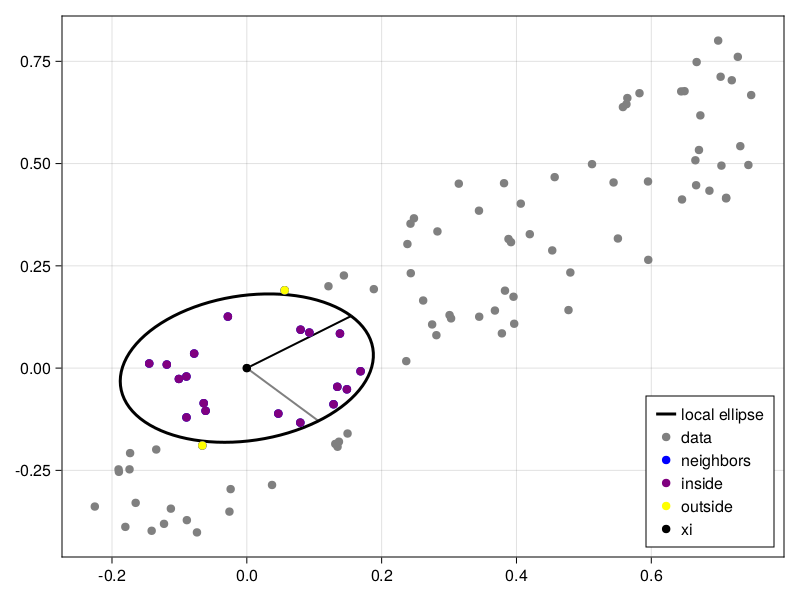

In [20]:
j = 5
α = 0.5
n = 100
X, V = rand(n), rand(n)
Y = X + α * V
data = StateSpaceSet(X, Y)
xᵢ, C, A, U, Σ, Vt, rs, neighborsᵢ, c, k_inside, ϵᵢ = 
    anim_entropy(Shannon(), Lord(k = 20), data; j);
X1, X2 = columns(data)
pts = [Point2f(pt - xᵢ) for pt in data]
nns = [Point2f(nn - xᵢ) for nn in neighborsᵢ]
centered_xᵢ = Point2f(xᵢ - xᵢ)

Λ = CausalityTools.hyperellipsoid_matrix(Vt, rs)
#rotated_nns = [inv(Vt) * pt for pt in nns]
inside = [transpose(pt) * Λ * pt <= 1 for pt in nns]
outside = [transpose(pt) * Λ * pt > 1 for pt in nns]

let	
    f = Figure()
    ax = Axis(f[1, 1])

    # Plot the ellipse and its semi-axes, from the origin
    θ = atan(Vt[:, 1][2], Vt[:, 1][1]) # angle of the first direction relative to x-axis
    ellipse = getellipsepoints(centered_xᵢ[1], centered_xᵢ[2], rs[1], rs[2], θ) # everything is shifted
	first_axis = [Point2f(centered_xᵢ), Point2f(centered_xᵢ + rs[1] * Vt[:, 1])]
    second_axis =  [Point2f(centered_xᵢ), Point2f(centered_xᵢ + rs[2] * Vt[:, 2])]
    lines!(ax, first_axis, linewidth = 2, color = :black)
    lines!(ax, second_axis, linewidth = 2, color = :grey)
    lines!(ax, ellipse[1], ellipse[2], color = :black, linewidth = 3, label = "local ellipse")
    

    # # Shift all data to `xᵢ` (so that `xᵢ` is in the origin), and 
    # # plot it.
    scatter!(ax, pts, label = "data",
        color = :grey)
    scatter!(ax, nns, label = "neighbors", 
        color = :blue)
    scatter!(ax, nns[inside], label = "inside", 
        color = :purple)
    scatter!(ax, nns[outside], label = "outside", 
        color = :yellow)
    #scatter!(ax, data[:, 1], data[:, 2])
    #scatter!(ax, neighborsᵢ[:, 1], neighborsᵢ[:, 2])
    scatter!(ax, centered_xᵢ, color = :black, label = "xi")

    axislegend(position = :rb)
    return f
end


In [6]:
# Different data with known mutual information from Lord et al.

function family1(α, n::Int)
    x = rand(n)
    v = rand(n)
    y = x + α * v
    return StateSpaceSet(x), StateSpaceSet(y)
end

function family3(α, n::Int)
    Σ = [
       7 -5 -1 -3;
       -5 5 -1 3;
       -1 -1 3 -1;
       -3 3 -1 2+α]
    N4 = MvNormal(zeros(4), Σ)
    D4 = StateSpaceSet([rand(N4) for i = 1:n])
    X = D4[:, 1:2]
    Y = D4[:, 3:4]
    return X, Y
end

# True mutual information values for these data
using LinearAlgebra
function ifamily1(α; base = ℯ)
    mi = -log(α) - α - log(2)
    return mi / log(ℯ, base)
end

function ifamily3(α; base = ℯ)
    Σ = [
       7 -5 -1 -3;
       -5 5 -1 3;
       -1 -1 3 -1;
       -3 3 -1 2+α]
    Σx = Σ[1:2, 1:2]
    Σx = Σ[3:4, 3:4]
    mi = 0.5*log(det(Σx) * det(Σx) / det(Σ))
    return mi / log(ℯ, base)
end


ifamily3 (generic function with 1 method)

In [7]:
using LaTeXStrings
function new_cycle_theme()
    # https://nanx.me/ggsci/reference/pal_locuszoom.html
    my_colors = ["#D43F3AFF", "#EEA236FF", "#5CB85CFF", "#46B8DAFF",
        "#357EBDFF", "#9632B8FF", "#B8B8B8FF"]
    cycle = Cycle([:color, :linestyle, :marker], covary=true) # alltogether
    my_markers = [:circle, :rect, :utriangle, :dtriangle, :diamond,
        :pentagon, :cross, :xcross]
    my_linestyle = [nothing, :dash, :dot, :dashdot, :dashdotdot]
    return Theme(
        fontsize = 22, font="CMU Serif",
        colormap = :linear_bmy_10_95_c78_n256,
        palette = (
            color = my_colors, 
            marker = my_markers, 
            linestyle = my_linestyle,
        ),
        Axis = (
            backgroundcolor= (:white, 0.2), 
            xgridstyle = :dash, 
            ygridstyle = :dash
        ),
        Lines = (
            cycle= cycle,
        ), 
        ScatterLines = (
            cycle = cycle,
        ),
        Scatter = (
            cycle = cycle,
        ),
        Legend = (
            bgcolor = (:grey, 0.2), 
            framecolor = (:white, 0.2),
            labelsize = 13,
        )
    )
end

run(est; f::Function, # function that generates data
        base::Real = ℯ, 
        nreps::Int = 10, 
        αs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
        n::Int = 500) =
    map(α -> mutualinfo(Shannon(; base), est, f(α, n)...), αs)

function compute_results(f::Function; estimators, k = 5, k_lord = 20,
        n = 1000, base = ℯ, nreps = 3)
    as = 7:-1:0
    αs = [1/10^(a) for a in as]
    is = [zeros(length(αs)) for est in estimators]
    for (k, est) in enumerate(estimators)
        tmp = zeros(length(αs))
        for i = 1:nreps
            tmp .+= run(est; f = f, αs, base, n)
        end
        is[k] .= tmp ./ nreps
    end

    return αs, as, is
end

function plot_results(f::Function, ftrue::Function; 
        base, estimators, k_lord, k, kwargs...)
    αs, as, is = compute_results(f; base, estimators, k_lord, k, kwargs...)
    set_theme!(new_cycle_theme())

    ymin = floor(Int, minimum(Iterators.flatten(is)))
    ymax = ceil(Int, maximum(Iterators.flatten(is)))
    f = Figure()
    ax = Axis(f[1, 1],
        xlabel = "α", ylabel = "I (nats)",
        xscale = log10, aspect = 1,
        xticks = (αs, [latexstring("10^{$(-a)}") for a in as]),
        yticks = (ymin:ymax)
        )
    xlims!(ax, (1e-7, 1e-0),)
    ylims!(ax, (ymin, ymax))
    lines!(ax, αs, [ftrue(α; base) for α in αs], 
        label = "I (true)", linewidth = 4, color = :black)
    for (i, est) in enumerate(estimators)
        es = string(typeof(est).name.name)
        lbl = est isa Lord ? "$es (k = $k_lord)" : "$es (k = $k)"
        scatter!(ax, αs, is[i], label = lbl)
        lines!(ax, αs, is[i])

    end
    axislegend()
    return f
end

plot_results (generic function with 1 method)

In [50]:
fig = with_theme(new_cycle_theme()) do 

    k_lord = 20
    k = 5
    base = ℯ

    estimators = [
        Lord(; k = k_lord),
        Kraskov(; k), 
        KozachenkoLeonenko(),
        Zhu(; k), 
        ZhuSingh(; k),
        GaoNaive(; k),
        GaoNaiveCorrected(; k),
        KSG1(; k), 
        KSG2(; k),
    ]
    return plot_results(family1, ifamily1; 
        k_lord = k_lord, k = k, 
        estimators = estimators,
        base = base)
end

In [47]:
htrue = 0.5*(1 + log(2π*det([14 7; 7 12]))) 
N2 = MvNormal([1, 4], [14 7; 7 12])
X = StateSpaceSet([rand(N2) for i = 1:100000])
h_krask = information(Shannon(; base = ℯ), Kraskov(k = 5), X)
h_lord = information(Shannon(; base = ℯ), Lord(k = 30), X)
htrue, h_krask, h_lord

(3.8085002797604375, 3.623143098568017, 5.159445273146853)

3.8085002797604375